# Transforming the product categories to word embedding vectors

IMPORTANT REMARK:

This code shall be executed from start to finish in the defined order. Errors may occur if the cells are executed in a different order.

In [1]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud, STOPWORDS
import gensim
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In the previous section, the items contained in the dataset have been assigned a product category:

In [2]:
productCategoriesDf = pd.read_excel('./product_categories.xlsx')
productCategoriesDf.head()

,item,desc,link,category
0,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,https://www.amazon.com/Sony-Ericsson-S500i-Slo...,Cell Phones & Accessories › Cell Phones › Unlo...
1,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,https://www.amazon.com/Sony-PSP-Slim-Lite-2000...,Video Games › Sony PSP › Consoles
2,ipod-touch-apple-8gb-with-software-upgra,iPod Touch Apple 8GB with Software Upgrade,https://www.amazon.com/Apple-touch-Generation-...,Electronics › Portable Audio & Video › MP3 & M...
3,lg-ku990-viewty-unlocked-black,LG KU990 Viewty Unlocked Black,https://www.amazon.com/gp/product/B000W88J4Y,Cell Phones & Accessories › Cell Phones › Unlo...
4,logitech-cordless-wave-keyboard-and-mous,Logitech Cordless Wave Keyboard and Mouse,https://www.amazon.com/Logitech-Cordless-Deskt...,Electronics › Computers & Accessories › Comput...


However, there 1769 items in total and 413 categories! A way to find clusters for these categories must be found so that the categories are useful when performing analyses.

In [3]:
print("Number of items : "+ str(len(productCategoriesDf['desc'].unique())))
print("Number of categories : "+str(len(productCategoriesDf['category'].unique())))

Number of items : 1769
Number of categories : 413


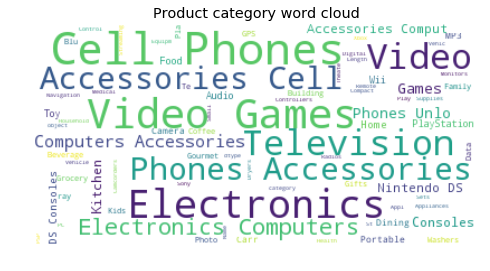

In [4]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(productCategoriesDf['category']))

fig = plt.figure(1)
plt.figure(figsize=(8,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Product category word cloud')
plt.show()

The category is divided into several sub-categories, which goes from a very general one (such an "Electronics"), to a very specified one (for example, "LED & LCD TVs").

In [5]:
productCategoriesDf['category'].value_counts()

Electronics › Computers & Accessories › Computers & Tablets › Laptops › Traditional Laptops                                   105
Electronics › Television & Video › Televisions › LED & LCD TVs                                                                 85
Cell Phones & Accessories › Cell Phones › Unlocked Cell Phones                                                                 80
Clothing, Shoes & Jewelry › Men › Watches › Wrist Watches                                                                      51
Toys & Games › Building Toys › Building Sets                                                                                   49
Movies & TV › Blu-ray › Movies                                                                                                 49
Video Games › PlayStation 3 › Games                                                                                            45
Video Games › Kids & Family › Wii › Games                                                 

Google's pre-trained Word2Vec model includes word vectors for a vocabulary of 3 million words and phrases that they trained on roughly 100 billion words from a Google News dataset. The vector length is 300 features.

A good way to cluster the product categories is to group the ones that have similar semantic meanings. A numerical representation of a product category semantic meaning can consist on a word vector that encompasses the meaning of all of the words contained in the product category string. These word vectors can later be used to define clusters according to the distances between them.

Since the size of the model is 1.5GB, it is not included in the GitHub folder. Nevertheless, for the next piece of code to work, the model should be downloaded and put in the corresponding folder.

The link to download the model is:
https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

Since Google's pre-trained Word2Vec model is a very big file, and is roughly in most- to least- frequent order, the parameter limit = 600000 is used to get the most-frequent 600000 words' vectors, saving both memory and load time.

In [6]:
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True, limit = 600000)

As it will later be seen, some of the words contained in the product categories cannot be found in the model. Therefore, a word-to-word mapping has been defined to replace the words that not exist in the vocabulary with other words that have a similar semantic meaning (and exist in the vocabulary).

If a word is not found in the mapping function, the output word is "invalidword". The reason why some of the words have not been mapped is because they did not add any relevant semantic meaning to the whole product category string.

In [7]:
def unknown_words_mapper(input_word):
    switcher = {
        "keyboards": "keyboard",
        "dslr": "reflex",
        "epilators":"shaver",
        "epilator":"shaver",
        "parfum":"perfume",
        "eau":"perfume",
        "blu-ray":"bluray",
        "screwpull":"corkscrew",
        "moka":"coffee",
        "grown-up":"mature",
        "semi-automatic":"automatic",
        "serveware":"bowl",
        "built-in":"inherent",
        "monopods":"monopod",
        "hdmi":"hd",
        "blackhead":"pimple",
        "playmats":"mat",
        "multitools":"tool",
        "ionizers":"ionize",
        "swoopo": "others",
    }
    output_word = switcher.get(input_word, "invalidword")
    print('The word \''+input_word+ '\' is mapped to \''+output_word+'\'')
    return output_word

The following code is used to iterate throughout all of the product categories and obtain a vector encompasses the global semantic meaning of the category. In order to do so, each single word contained in the product category is analyzed separately and a vector is obtained for it. Then, the average of the word embedding vectors of the words that compose the product category is obtained. This final vector represents the global semantic meaning of the product category.

In [8]:
wnl = WordNetLemmatizer()

#punctuation characters to be skipped if they are contained in the product category string
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%","-"]

productDescriptionToSimilarWords = {}
productDescriptionToVector = {}

for i, row in productCategoriesDf.iterrows():
    #product category string
    productCompleteCategoryString = row['category']
    #product description
    productDescription = row['desc']
    
    #the product category string is compossed of several categories separated by the symbol ">"
    productCompleteCategory = productCompleteCategoryString.split(' › ')

    numberOfValidWords = 0
    #in order to calculate the average of the word embedding vectors, it is necessary to
    #sum the word vectors. The vector length is 300 features.
    productSigleCategoryWordSummedVector = [0] * 300
    
    for productSingleCategory in productCompleteCategory:
        for productSingleCategoryWordMaybePaired in productSingleCategory.split():
            #Some categories contain hyphenated compound words, such as "Super-Automatic Espresso Machines",
            #"Single-Serve Brewers", "App-Controlled Figures & Robots", etc.
            for productSingleCategoryWord in productSingleCategoryWordMaybePaired.split("-"):
                #lowercase version
                productSingleCategoryWord = productSingleCategoryWord.lower()
                #lemmatized version
                productSingleCategoryWord = wnl.lemmatize(productSingleCategoryWord)
                  
                lastCharacter = productSingleCategoryWord[-1:]
                if lastCharacter in punc:
                    #Some categories contain punctuation characters (commas, for example).
                    #For instance, the following category contains a comma: Keyboards, Mice & Accessories
                    
                    #the punctuation character is removed
                    productSingleCategoryWord = productSingleCategoryWord[:-1]
    
                try:
                    #vector assigned to the word by the model
                    vector = model[productSingleCategoryWord]
                    numberOfValidWords += 1
                                
                except Exception as e:
                    print ("Product description: "+productDescription+" ; Product category: "+productCompleteCategoryString)
                    #an exception raises when one of the words contained in the product category string
                    #is not found in the vocabulary
                    print(e)
                    
                    #manually-defined mapping for some of the words that are not contained in the vocabulary
                    productSingleCategoryOriginalWord = productSingleCategoryWord
                    productSingleCategoryWord = unknown_words_mapper(productSingleCategoryWord)
                    
                    if productSingleCategoryWord == "invalidword":
                        print('A word mapping could not be found for the word \''+productSingleCategoryOriginalWord+'\'. So this word is skipped.')
                        #the word is skipped
                        continue
                        
                    #vector assigned to the word by the model
                    vector = model[productSingleCategoryWord]
                    numberOfValidWords += 1
                
                #the word vector for the word that is currently being analyzed is summed to the sum of the
                #previous word vectors for this category.
                productSigleCategoryWordSummedVector = productSigleCategoryWordSummedVector + vector
                
    
    #average of the word embedding vectors
    meanVector = productSigleCategoryWordSummedVector/numberOfValidWords
    #most similar words to the average vector
    mostSimilarByVectorWords = model.wv.similar_by_vector(meanVector)
    
    #print(productDescription)
    #print(mostSimilarByVectorWords)
    #print('-------')
    
    if productDescription not in productDescriptionToVector:
        #dictionary: product description to average of the word embedding vectors
        productDescriptionToVector[productDescription] = meanVector    
    if productDescription not in productDescriptionToSimilarWords:
        #dictionary: product description to the most similar words
        productDescriptionToSimilarWords[productDescription] = mostSimilarByVectorWords                           

/home/dsc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Product description: Canon Digital Rebel XSi + 18-55mm Lens Black ; Product category: Electronics › Camera & Photo › Digital Cameras › DSLR Cameras
"word 'dslr' not in vocabulary"
The word 'dslr' is mapped to 'reflex'
Product description: Microsoft Xbox 360 Deluxe Bundle + Forza  2 ; Product category: Video Games › Xbox 360 › Consoles
"word '360' not in vocabulary"
The word '360' is mapped to 'invalidword'
A word mapping could not be found for the word '360'. So this word is skipped.
Product description: $80 Cash! ; Product category: Swoopo
"word 'swoopo' not in vocabulary"
The word 'swoopo' is mapped to 'others'
Product description: $1,000 Cash! ; Product category: Swoopo
"word 'swoopo' not in vocabulary"
The word 'swoopo' is mapped to 'others'
Product description: 50 FreeBids Voucher ; Product category: Swoopo
"word 'swoopo' not in vocabulary"
The word 'swoopo' is mapped to 'others'
Product description: 300 FreeBids Voucher ; Product category: Swoopo
"word 'swoopo' not in vocabulary"

Product description: Star Wars: The Force Unleashed (Xbox 360) ; Product category: Video Games › Xbox 360 › Games
"word '360' not in vocabulary"
The word '360' is mapped to 'invalidword'
A word mapping could not be found for the word '360'. So this word is skipped.
Product description: $1000 iPhone 3G Gift Card ; Product category: Swoopo
"word 'swoopo' not in vocabulary"
The word 'swoopo' is mapped to 'others'
Product description: Yves Saint Laurent Kouros 1.6oz. edt for men ; Product category: Beauty & Personal Care › Fragrance › Men's › Eau de Toilette
"word 'eau' not in vocabulary"
The word 'eau' is mapped to 'perfume'
Product description: Gucci Rush for Women EDT Spray 1.7 Oz. ; Product category: Beauty & Personal Care › Fragrance › Women's › Eau de Toilette
"word 'eau' not in vocabulary"
The word 'eau' is mapped to 'perfume'
Product description: Opium By Yves Saint Laurent Men's EDT Spray 3.3 Oz ; Product category: Beauty & Personal Care › Fragrance › Men's › Eau de Toilette
"word

Product description: Emeril Desert Dunes 3-Piece Appetizer Serving Set ; Product category: Home & Kitchen › Emeril Lagasse › Tableware
"word 'emeril' not in vocabulary"
The word 'emeril' is mapped to 'invalidword'
A word mapping could not be found for the word 'emeril'. So this word is skipped.
Product description: Emeril Desert Dunes 3-Piece Appetizer Serving Set ; Product category: Home & Kitchen › Emeril Lagasse › Tableware
"word 'lagasse' not in vocabulary"
The word 'lagasse' is mapped to 'invalidword'
A word mapping could not be found for the word 'lagasse'. So this word is skipped.
Product description: 20 Bids Voucher ; Product category: Swoopo
"word 'swoopo' not in vocabulary"
The word 'swoopo' is mapped to 'others'
Product description: Monster Ultra 600 HDmi Video Cable - 4' ; Product category: Electronics › Accessories & Supplies › Audio & Video Accessories › Cables & Interconnects › Video Cables › HDMI Cables
"word 'hdmi' not in vocabulary"
The word 'hdmi' is mapped to 'hd'
P

Product description: Microsoft Xbox 360 Pro Gaming Console ; Product category: Video Games › Xbox 360 › Consoles
"word '360' not in vocabulary"
The word '360' is mapped to 'invalidword'
A word mapping could not be found for the word '360'. So this word is skipped.
Product description: Halo 3: ODST (Xbox 360) ; Product category: Video Games › Xbox 360 › Games
"word '360' not in vocabulary"
The word '360' is mapped to 'invalidword'
A word mapping could not be found for the word '360'. So this word is skipped.
Product description: Leatherman Charge TTi Multi-Tool ; Product category: Tools & Home Improvement › Power & Hand Tools › Hand Tools › Multitools & Accessories › Multitools
"word 'multitools' not in vocabulary"
The word 'multitools' is mapped to 'tool'
Product description: Leatherman Charge TTi Multi-Tool ; Product category: Tools & Home Improvement › Power & Hand Tools › Hand Tools › Multitools & Accessories › Multitools
"word 'multitools' not in vocabulary"
The word 'multitools' i

Product description: Canon EOS Rebel T1i + 18-55mm + 150 FreeBids ; Product category: Electronics › Camera & Photo › Digital Cameras › DSLR Cameras
"word 'dslr' not in vocabulary"
The word 'dslr' is mapped to 'reflex'
Product description: Nikon D90 with 18-105mm Kit + 150 FreeBids ; Product category: Electronics › Camera & Photo › Digital Cameras › DSLR Cameras
"word 'dslr' not in vocabulary"
The word 'dslr' is mapped to 'reflex'


After having executed the previous function, two dictionaries are obtained. One of them contains a mapping of the product description to some words and probabilities. These words are the most similar ones to the average of the word embedding vectors of the words contained in the product category string. The ones with a higher probability are more similar than the ones with a lower probability. 

This dictionary is not used for the product category clustering. It is just useful to check that the average vector represents a fairly correct semantic meaning for the product description that it belongs to.

For example, the list of words that are similar to the average vector for the product description "PSP Slim & Lite Sony Piano Black" are: PSP, Sony, console, etc.

In [9]:
productDescriptionToSimilarWords['PSP Slim & Lite Sony Piano Black']

[('psp', 0.8223001956939697),
 ('sony', 0.7712065577507019),
 ('ps3', 0.7491242289543152),
 ('ps2', 0.7487238645553589),
 ('console', 0.7378007173538208),
 ('xbox###', 0.7354203462600708),
 ('PS3', 0.728268027305603),
 ('Ps3', 0.7219930291175842),
 ('Xbox###', 0.7113896012306213),
 ('xbox', 0.706906259059906)]

The second dictionary contains a mapping of the product description to the average of the word embedding vectors. The distances defined by these vectors is what will allow to cluster the product categories.

Each one of these vectors has a length of 300 features:

In [10]:
productDescriptionToVector['PSP Slim & Lite Sony Piano Black']

array([ 0.08103027, -0.06135864, -0.00546875,  0.08585815, -0.01098633,
        0.08955078,  0.11704102, -0.01992187,  0.12749023,  0.06430664,
       -0.18666992, -0.15029297, -0.10481606, -0.02753906,  0.05692139,
        0.03928223,  0.06899414,  0.0253418 ,  0.0157959 , -0.25517578,
        0.17158203,  0.07627792,  0.15625   , -0.04321289, -0.07583008,
        0.01455078, -0.11552734,  0.20205078,  0.12456055, -0.20906982,
       -0.01166992,  0.21630859, -0.09394531, -0.08334961, -0.19487305,
       -0.08100586, -0.05698242,  0.07900391,  0.07720032, -0.01889648,
        0.05257874,  0.08672485,  0.20588379,  0.16879883, -0.0690918 ,
       -0.05673828,  0.06098633, -0.04125977,  0.08149719, -0.09311523,
       -0.03153076, -0.00046997,  0.16434326, -0.02139893, -0.11101837,
       -0.0137207 , -0.02705078,  0.01210938,  0.12668457, -0.08461914,
       -0.062854  ,  0.1671875 , -0.23959961,  0.03632813, -0.24570312,
        0.01425781, -0.11894531, -0.05350342,  0.03261719,  0.15

There are several clustering methods, and even when the same clustering method is used, the values that are chosen for the parameters will change the clusters that are obtained. However, the input vectors used for the clustering are always the same ones. These vectors have been saved in a new file, so that it is easy to have access to them in the future if needed (for example, to try another clustering method).

In [11]:
productDescriptionToVectorDf = pd.DataFrame(productDescriptionToVector)

In [12]:
productDescriptionToVectorDf.to_excel('./productDescriptionToVector.xlsx')